In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.circuit.quantumcircuit import QubitSpecifier
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram
from typing import List

import numpy as np
import random

from ryQFTAdder import *

# Find the Largest Number (basic ver.)

This part demonstrate the quantum algorithm to solve task 1

## QRAM

We begin with defining how the data in the list can be accessed quantumly. Though a QRAM is not required for solving the original task 1, it will be used nontrivially when we extent the problem in the next section.

We want a circuit $U_f$ such that:

$$
\ket{i}\ket{0} \xrightarrow{U_f} \ket{i}\ket{f(i)}
$$

where $i$ is the index and $f(i)$ gives the ith number in the list.

For each integer in the list, we choose basic/state encoding, the highest bit is sign bit. For example, 5 and -6 can be encoded as:

$$\begin{align*}
5  &\rightarrow \ket{00101} \\
-6 &\rightarrow \ket{11010}      
\end{align*}$$

4 bits is enough to hold 5 and -6. Since we'll later do addition and subtraction between two numbers in the list, we use 1 extra bit to prevent overflow. The indeices will be encoded by state encoding and we encode the them into the ctrl bits of mcx gate. The control bit will be controlled by either '0' or '1' based on the state encoding of the index on that position.

In [2]:
"""
Here is a general method to convert a list of number into quantum data.

In this function, we used np.max to find the bound for the list, 
but such information is not encoded into the QRAM so the algorithm that we'll 
present in a moment to solve the problem will not lost any generality. And in practice 
the bound on integer is always predetermined by its type like 'int' in C usually represents 
integers from -2147483648 to 2147483647. The reason that we choose to dynamically determine 
the number of qubit is for compactness and clarity.

"""

def toQRAM(
    data_list: List[int],
    num_idx_cbit: int = None,
    num_data_cbit: int = None,
    apply_H: bool = False
) -> QuantumCircuit:
    """
        returns the circuit U_f such that U_f|i>|0> = |i>|x_i>

        Args:
            data_list:
                the list of number needs to be encoded

            num_data_cbit:
                size of the classical register of for the data qubit

            apply_H:
                if set to `True` will add Hadamard gate on all index qubits
                before the qram circuit
    """
    
    # first construct qram as a gate 

    # define minimum number of qubit to represent all the integers in the list
    bound = np.max(np.abs(data_list))
    num_qubit_i = int(np.ceil(np.log2(len(data_list))))
    num_qubit_xi = len(bin(bound)[2:]) + 2 # one for sign and one for preventing overflow

    if None == num_idx_cbit:
        num_idx_cbit = num_qubit_i
    if None == num_data_cbit:
        num_data_cbit = num_qubit_xi
    
    # define index and data quantum registers
    reg_i  = QuantumRegister(num_qubit_i)
    reg_xi = QuantumRegister(num_qubit_xi)
    
    qc = QuantumCircuit(reg_i, reg_xi, name="QRAM")

    for i, x in enumerate(data_list):
        # convert index into binary and agree with the number of index qubit
        i_bin = format(i, f'0{num_qubit_i}b') 
        # convert x_i into binary and agree with the number of data qubit
        x_bin = bin(x & int('1' * num_qubit_xi, 2))[2:]

        # determine which control bit is controlled by '0'
        for i_bin_idx, i_bin_symbol in enumerate(reversed(i_bin)):
            if '0' == i_bin_symbol:
                qc.x(reg_i[i_bin_idx])
        
        # encode x_i
        for x_bin_idx, x_bin_symbol in enumerate(reversed(x_bin)):
            if '1' == x_bin_symbol:
                qc.mcx(reg_i, reg_xi[x_bin_idx])
        
        # uncompute for the control bit
        for i_bin_idx, i_bin_symbol in enumerate(reversed(i_bin)):
            if '0' == i_bin_symbol:
                qc.x(reg_i[i_bin_idx])

    # define qram as a gate
    qram_gate = qc.to_gate()

    # using the qram gate, construct the full circuit 
    q_i  = QuantumRegister(num_qubit_i, "q_i")
    q_xi = QuantumRegister(num_qubit_xi, "q_xi")
    c_i = ClassicalRegister(num_idx_cbit, "i")
    c_xi = ClassicalRegister(num_data_cbit, "xi") 

    full_circ = QuantumCircuit(q_i, q_xi)
    if 0 != num_idx_cbit:
        full_circ.add_register(c_i)
    if 0 != num_data_cbit:
        full_circ.add_register(c_xi)
    
    if apply_H:
        full_circ.h(q_i)

    full_circ.append(qram_gate, range(full_circ.num_qubits))

    return full_circ

For example the list [-3,2,5,-1] in the qram form will be:

In [3]:
ex_list = [-3, 2, 5, 1]

qram_circ = toQRAM(ex_list)
qram_circ.decompose().draw()

┌───┐                    ┌───┐          ┌───┐          ┌───┐     
 q_i_0: ┤ X ├──■────■────■────■──┤ X ├───────■──┤ X ├──■────■──┤ X ├──■──
        ├───┤  │    │    │    │  ├───┤┌───┐  │  ├───┤  │    │  └───┘  │  
 q_i_1: ┤ X ├──■────■────■────■──┤ X ├┤ X ├──■──┤ X ├──■────■─────────■──
        └───┘┌─┴─┐  │    │    │  └───┘└───┘  │  └───┘┌─┴─┐  │       ┌─┴─┐
q_xi_0: ─────┤ X ├──┼────┼────┼──────────────┼───────┤ X ├──┼───────┤ X ├
             └───┘  │    │    │            ┌─┴─┐     └───┘  │       └───┘
q_xi_1: ────────────┼────┼────┼────────────┤ X ├────────────┼────────────
                  ┌─┴─┐  │    │            └───┘          ┌─┴─┐          
q_xi_2: ──────────┤ X ├──┼────┼───────────────────────────┤ X ├──────────
                  └───┘┌─┴─┐  │                           └───┘          
q_xi_3: ───────────────┤ X ├──┼──────────────────────────────────────────
                       └───┘┌─┴─┐                                        
q_xi_4: ────────────────────┤ X ├────────────────────────────────────────
                            └───┘                                        
   i: 2/═════════════════════════════════════════════════════════════════
                                                                         
  xi: 5/═════════════════════════════════════════════════════════════════

And we can confirm the qram indeed stores the desired data by making queries on all possible indices:

In [4]:
query_circ = QuantumCircuit(qram_circ.qregs[0])
# equal superposition on all indices
query_circ.h(query_circ.qregs[0])

# add the query in fron of the qram
query_circ = qram_circ.compose(query_circ, qram_circ.qregs[0], front=True)
# query_circ.append(qAdder(-1, query_circ.qregs[1].size), query_circ.qregs[1])

# measure and get results of the queries
query_circ.measure(query_circ.qregs[0], query_circ.cregs[0])
query_circ.measure(query_circ.qregs[1], query_circ.cregs[1])

query_circ.draw()

┌───┐┌───────┐┌─┐                  
 q_i_0: ┤ H ├┤0      ├┤M├──────────────────
        ├───┤│       │└╥┘┌─┐               
 q_i_1: ┤ H ├┤1      ├─╫─┤M├───────────────
        └───┘│       │ ║ └╥┘┌─┐            
q_xi_0: ─────┤2      ├─╫──╫─┤M├────────────
             │       │ ║  ║ └╥┘┌─┐         
q_xi_1: ─────┤3 QRAM ├─╫──╫──╫─┤M├─────────
             │       │ ║  ║  ║ └╥┘┌─┐      
q_xi_2: ─────┤4      ├─╫──╫──╫──╫─┤M├──────
             │       │ ║  ║  ║  ║ └╥┘┌─┐   
q_xi_3: ─────┤5      ├─╫──╫──╫──╫──╫─┤M├───
             │       │ ║  ║  ║  ║  ║ └╥┘┌─┐
q_xi_4: ─────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├
             └───────┘ ║  ║  ║  ║  ║  ║ └╥┘
   i: 2/═══════════════╩══╩══╬══╬══╬══╬══╬═
                       0  1  ║  ║  ║  ║  ║ 
  xi: 5/═════════════════════╩══╩══╩══╩══╩═
                             0  1  2  3  4

In [5]:
print("Original list: ", ex_list)

# run the circuit to get the result of the queries
simulator = Aer.get_backend('qasm_simulator')
result = execute(query_circ, simulator).result()
counts = result.get_counts()
# raw output in binary
print("Query raw data: ", counts)

# extract original classical data 
print("Decoded result: ")
for xi_i in counts:
    xi_bin, i_bin = xi_i.split(" ")
    
    # have to consider the sign when convert back into integer 
    sign_bit = xi_bin[0]
    xi = int(xi_bin[1:], 2)
    if '1' == sign_bit:
        xi = -(2**(len(xi_bin)-1) - xi)
    # index is unsigned
    i = int(i_bin, 2)

    print(f"f[{i}]: {xi}")

Original list:  [-3, 2, 5, 1]
Query raw data:  {'11101 00': 268, '00101 10': 237, '00010 01': 266, '00001 11': 253}
Decoded result: 
f[0]: -3
f[2]: 5
f[1]: 2
f[3]: 1


We can see the recovered data is exactly the same as the original list

## Quantum-classical Adder

With classically given integer X, positive or negative, we want the adder to do:

$$
    \ket{n} \xrightarrow{} \ket{n + X}
$$

There are many different methods, here we choose an implementation in fourier basis. Both the fourier transform defined by y-rotation and the addition circuit in such basis are proposed by Rich Rines & Isaac Chuang^[1]. Detailed implementation is in `ryQFTAdder.py`.

[1]: Rines, R., & Chuang, I. (2018). High Performance Quantum Modular Multipliers. [arXiv:1801.01081](https://arxiv.org/abs/1801.01081).

## Quantum Comparator

Now we want to implement a gate $U_{a<X}$ that encode the comparison result into phase:
- partial version
$$
U_{a<X,p}\ket{a} = (-1)^{a<X}\ket{a-X}
$$ 

- complete version
$$
U_{a<X,c}\ket{a} = (-1)^{a<X}\ket{a}
$$

They only differ by a quantum addition of `X`. The key idea for building both is to apply a `Z` gate on the highest data qubit after adding `-X` to $\ket{a}$. When the highest bit of `(a - X)` is $1$, $a-X<0$, $a<X$, $-1$ phase is added. When the highest bit of `(a - X)` is $0$, $Z\ket{0}=\ket{0}$, no phase is added.

In [6]:
def complete_comparator(
    X: int,
    circuit: QuantumCircuit,
    target_reg: QuantumRegister,
    invert_sign: bool = False
):
    """
        |a>  ---> (-1)^{(a<X)} |a>

        invert_sign: `bool`
            If set to `True`, (-1) phase will be added only when `a>=X`.
            If set to `False`, (-1) phase will be added only when `a<X`.

    """

    # |a> to | a - X >
    circuit.append(qAdder(-X, target_reg.size), target_reg)

    if invert_sign:
        circuit.x(target_reg[-1])

    circuit.z(target_reg[-1])

    if invert_sign:
        circuit.x(target_reg[-1])

    circuit.append(qAdder(X, target_reg.size), target_reg)

    return

### controlled quantum comparator

The controlled quantum comparator is a unitary, $\text{c-}U_{a<X}$, that applys quantum comparator when the control bit is $1$:

- partial version
$$
\text{c-}U_{a<X,p}\ket{i}\ket{a} = (-1)^{(a<X)\cdot i}\ket{i}\ket{a-X}
$$

- full version
$$
\text{c-}U_{a<X,c}\ket{i}\ket{a} = (-1)^{(a<X)\cdot i}\ket{i}\ket{a}
$$

to get a controlled comparator, we only have to change the `Z` gate in the quantum comparator to a `CZ` gate controlled by the control bit $\ket i$.

In [7]:
def partial_ctl_comparator(
    X: int,
    circuit: QuantumCircuit,
    ctl_qubit: QubitSpecifier,
    target_reg: QuantumRegister,
    invert_sign: bool = False
):
    """
        |i>|a>  ---> (-1)^{(a<X)*i} |a - X >

        invert_sign: `bool`
            If set to `True`, (-1) phase will be added only when `a>=X`.
            If set to `False`, (-1) phase will be added only when `a<X`.

    """

    # |a> to | a - X >
    circuit.append(qAdder(-X, target_reg.size), target_reg)
    if invert_sign:
        circuit.x(target_reg[-1])
    circuit.cz(ctl_qubit, target_reg[-1])

    return

def complete_ctl_comparator(
    X: int,
    circuit: QuantumCircuit,
    ctl_qubit: QubitSpecifier,
    target_reg: QuantumRegister,
    invert_sign: bool = False
):
    """
        |i>|a>  ---> (-1)^{(a<X)*i} |a>

        invert_sign: `bool`
            If set to `True`, (-1) phase will be added only when `a>=X`.
            If set to `False`, (-1) phase will be added only when `a<X`.

    """

    # |a> to | a - X >
    circuit.append(qAdder(-X, target_reg.size), target_reg)

    if invert_sign:
        circuit.x(target_reg[-1])

    circuit.cz(ctl_qubit, target_reg[-1])

    if invert_sign:
        circuit.x(target_reg[-1])

    circuit.append(qAdder(X, target_reg.size), target_reg)

    return

Here is an example of a controlled partial comparator circuit. The result of `(-5 < -2)` will be stored in control qubit's phase when the control qubit is $\ket{1}$.

In [8]:
test_comp_circ = toQRAM([-5, 1], 0, 0)
test_comp_circ.barrier()
test_comp_circ.add_register(QuantumRegister(1, name="ctl"))
partial_ctl_comparator(
    X = -2,
    circuit= test_comp_circ,
    ctl_qubit= test_comp_circ.qregs[-1][0],
    target_reg= test_comp_circ.qregs[1]
)

test_comp_circ.draw()

┌───────┐ ░               
   q_i: ┤0      ├─░───────────────
        │       │ ░ ┌─────────┐   
q_xi_0: ┤1      ├─░─┤0        ├───
        │       │ ░ │         │   
q_xi_1: ┤2      ├─░─┤1        ├───
        │  QRAM │ ░ │         │   
q_xi_2: ┤3      ├─░─┤2 add(2) ├───
        │       │ ░ │         │   
q_xi_3: ┤4      ├─░─┤3        ├───
        │       │ ░ │         │   
q_xi_4: ┤5      ├─░─┤4        ├─■─
        └───────┘ ░ └─────────┘ │ 
   ctl: ────────────────────────■─

## Solution

The general idea is to implement a variation of the Deutsch's Algorithm. We first put $\ket 0$ to superposition: $H\ket{0}\rightarrow {1\over\sqrt{2}}(\ket{0}+\ket{1})$. Then we can use controlled quantum comparator and another hadamard gate to exract the value of `(a < b)`.

### algorithm

Now we have all the ingredients. Here's the algorithm to find the largest number from a list two integers `[a, b]` :

1. Let the index qubit in the default $\ket 0$ state. Apply qram circuit for the list `[a, b]`.
2. Use an extra qubit in $\ket{+}$ state to apply a (partial) controlled quantum comparator with `X = b` on the data register of the qram.
3. Apply `H` on the extra qubit.
4. Measure the extra qubit.
5. If the measurement result is `1`, `b` is the largest. If the measurement result is `0`, `a` is the largest.

### explanation

$$ 
\ket{0}\ket{a} 
\xrightarrow{H} {1\over\sqrt{2}}(\ket{0} + \ket{1})\ket{a} 
\xrightarrow{cU_{a<b,p}} {1\over\sqrt{2}}(\ket{0} +(-1)^{a<b}\ket{1})\ket{a-b}
\xrightarrow{H} \ket{a<b}\ket{a-b}
$$

### analysis

- The success rate for this algorithm is $1$ and we only have to run the quantum circuit for once.
- The number of qubit required for the algorithm is $O(\log(\max(a,b)))$ due to the implementation of qram.
- This algorithm works for all kinds of number. Because the qram, quantum-classical adder and the quantum comparator work for all integers.

### implementation


In [9]:
def find_the_largest_number(a, b, show_process: bool = False) -> int:

    num_list = [a,b]

    # step 1. |0>|a>
    qc = toQRAM(num_list, 0, 0)

    # step 2. |0>|a>(|0> + |1>)/√2  --> |0>|(a - b)>(|0> + (-1)^(a<b)|1>)/√2
    qc.add_register(QuantumRegister(1, name= "comp"))
    qc.h(qc.qregs[-1])
    qc.add_register(ClassicalRegister(1, name= "a<b"))

    partial_ctl_comparator(
        X          = b,
        circuit    = qc,
        ctl_qubit  = qc.qregs[-1][0],
        target_reg = qc.qregs[1]
    )

    # step 3. |0>|(a - b)>(|0> + (-1)^(a<b) |1>)/√2 --> |0>|(a - b)>|(a<b)>
    qc.h(qc.qregs[-1])

    # step 4. get measurement result of (b>a)
    qc.measure(qc.qregs[-1], qc.cregs[-1])
    # we only need to run the circuit once
    backend = Aer.get_backend('qasm_simulator')
    comp_result = execute(qc, backend,shots=1).result().get_counts()
    aLb = comp_result.most_frequent()[0]

    # optional print
    if show_process:
        print(qc)
        print("raw data: ", comp_result)
        print(f"a<b: {aLb}")

    # step 5. decide which one is the largest
    if '1' == aLb:
        return b

    return a

### some test cases

In [10]:
find_the_largest_number(5, -6, show_process=True)

        ┌───────┐                      
   q_i: ┤0      ├──────────────────────
        │       │┌─────────┐           
q_xi_0: ┤1      ├┤0        ├───────────
        │       ││         │           
q_xi_1: ┤2      ├┤1        ├───────────
        │  QRAM ││         │           
q_xi_2: ┤3      ├┤2 add(6) ├───────────
        │       ││         │           
q_xi_3: ┤4      ├┤3        ├───────────
        │       ││         │           
q_xi_4: ┤5      ├┤4        ├─■─────────
        └─┬───┬─┘└─────────┘ │ ┌───┐┌─┐
  comp: ──┤ H ├──────────────■─┤ H ├┤M├
          └───┘                └───┘└╥┘
 a<b: 1/═════════════════════════════╩═
                                     0 
raw data:  {'0': 1}
a<b: 0


5

In [11]:
def test_find_the_largest_number(
    int_range: int,
    num_tests: int
):  
    """
        For two randomly generated integers in range `[-int_range, int_range]`, run the quantum algorithm vs the classical max function
        to confirm the result is correct. The test will be run for `num_tests` times.
    """
    print("Case a = b:")
    for i in range(num_tests):
        a = random.randint(-int_range, int_range)
        b = a

        qMax = find_the_largest_number(a,b)
        cMax = max(a,b)
        print(f"testcase-{i} [{a}, {b}]: qMax = {qMax}, cMax = {cMax}. Results agree: {qMax == cMax}")


    # random tests
    print("\nRandom test (a>b or a<b):")
    for i in range(num_tests):
        a = random.randint(-int_range, int_range)
        b = random.randint(-int_range, int_range)

        qMax = find_the_largest_number(a,b)
        cMax = max(a,b)
        print(f"testcase-{i} [{a}, {b}]: qMax = {qMax}, cMax = {cMax}. Results agree: {qMax == cMax}")

    return 

In [12]:
test_find_the_largest_number(128, 5)

Case a = b:
testcase-0 [-102, -102]: qMax = -102, cMax = -102. Results agree: True
testcase-1 [-106, -106]: qMax = -106, cMax = -106. Results agree: True
testcase-2 [114, 114]: qMax = 114, cMax = 114. Results agree: True
testcase-3 [-74, -74]: qMax = -74, cMax = -74. Results agree: True
testcase-4 [10, 10]: qMax = 10, cMax = 10. Results agree: True

Random test (a>b or a<b):
testcase-0 [7, 84]: qMax = 84, cMax = 84. Results agree: True
testcase-1 [73, -33]: qMax = 73, cMax = 73. Results agree: True
testcase-2 [-7, 4]: qMax = 4, cMax = 4. Results agree: True
testcase-3 [5, 101]: qMax = 101, cMax = 101. Results agree: True
testcase-4 [108, -8]: qMax = 108, cMax = 108. Results agree: True


## Conclusion

Analysis and data both show that the proposed algorithm do solve the problem.

# Find the Largest Number (extented ver.)

## Problem Definition

We would like to consider a problem of finding the largest number in a list of integers with length larger than two. We'll assume all element are unique. We'll start with list having length $N=2^n$ for some integer $n$. Later we'll show how to apply this algorithm to list with arbitrary length. 

- list size = N =2^n for integer n.
- list elements are unique 

In [13]:
# from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator

## Grover Subroutine

Given a integer `X`  and a list of integers `[x_0, x_1, ..., x_(N-1)]`, and assume we know there're `r` items in the list that is greater than or equal to `X`. We want a grover subroutine that can find one of the number in the list that is greater than or equal to `X`.

We build the oracle gate using the qram and quantum comparator defined in previous sections. We use the `GroverOperator` in `qiskit` to generate the grover operator.

In [14]:
def build_comp_oracle(
    data_list: List[int],
    comp_target: int
) -> QuantumCircuit:
    
    """
        grover oracle gives any number in the list >= `comp_target` a (-1) phase

    """

    # encode the data, ready to be compared with `comp_target`
    oracle = toQRAM(
        data_list = data_list,
        num_idx_cbit = 0,
        num_data_cbit = 0
    )

    # add (-1) phase to all states that has value great than or equal to `comp_target`
    complete_comparator(
        X = comp_target,
        circuit = oracle,
        target_reg = oracle.qregs[1],
        invert_sign = True
    )

    # uncompute data register of the qram
    # (-1) phase saved in the index register
    qram_dg = oracle.data[0].operation.inverse()
    oracle.append(qram_dg, range(oracle.num_qubits))


    return oracle


def grover_find_larger_circuit(
    data_list: List[int],
    comp_target: int,
    num_iteration: int
) -> QuantumCircuit:
    """
        The complete circuit that runs grover's algorithm to find elements in the list 
        larger than or equal to `comp_target`
    """

    # build oracle 
    oracle = build_comp_oracle(data_list, comp_target)

    # based on the given oracle, build the grover operator
    grover_op = GroverOperator(
        oracle = oracle,
        reflection_qubits = [i for i in range(oracle.qregs[0].size)],
        insert_barriers=True
    )

    # build the full circuit
    search_circuit = QuantumCircuit(oracle.qregs[0], oracle.qregs[1])
    search_circuit.add_register(ClassicalRegister(oracle.qregs[0].size, name = "idx"))

    search_circuit.h(search_circuit.qregs[0])
    search_circuit.append(grover_op.repeat(num_iteration), range(search_circuit.num_qubits))

    search_circuit.measure(search_circuit.qregs[0], search_circuit.cregs[0])

    return search_circuit

Here's an example for finding all the element in the list that is larger than or equal to `X`

In [15]:
random.seed(4)

list_size = 2**6

input_list = random.sample(range(-list_size, list_size), list_size)

rand_idx = random.randint(0,list_size-1)
# X = max(input_list)
X = input_list[rand_idx]

# assume we know the number of target here
num_target = np.sum(np.array(input_list) >= X)
it = int(np.floor(np.pi*np.sqrt(list_size/num_target)/4))  # floor(pi/4*sqrt(N/M))

print(input_list)
print(f"X = {X}")
print(f"num of target: {num_target}")
print(f"num of iteration: {it}")


[-4, -26, -51, 28, -14, -3, -45, -53, -56, -62, -13, 6, -27, 38, 33, -57, -36, 2, 4, -18, -29, 35, -42, 61, -31, -37, -61, 18, 39, -30, -40, -43, -25, 51, 16, -17, 56, 13, -21, 21, -15, 0, -33, 41, 24, 63, 43, 27, 52, 62, -64, 30, 9, 31, 1, 49, -12, -10, -28, -9, -7, -44, -35, 10]
X = 51
num of target: 6
num of iteration: 2


In [16]:
grover_circuit = grover_find_larger_circuit(
    data_list = input_list,
    comp_target = X,
    num_iteration = it
)

# grover_circuit.decompose().decompose().decompose().draw()

In [17]:
grover_sim = Aer.get_backend('qasm_simulator')
search_stat = execute(grover_circuit, grover_sim, shots = 2**8).result().get_counts()

print(f"numbers larger than {X}:")
for key in search_stat.int_raw:
    print(input_list[key])

numbers larger than 51:
51
56
62
61
52
63


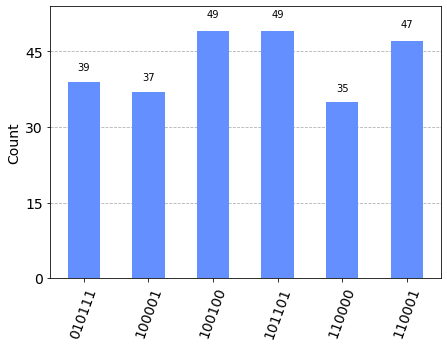

In [18]:
plot_histogram(search_stat)

## Solution

We've defined our grover subroutine. Now we can illustrate the algorithm to find the largest number.

### algorithm

First, a detailed description on the grover subroutine:


The grover_find_larger subroutine: GFL(list, iteration, X)
- Construct a grover operator with an oracle that will mark all elements' indices in `list` whose value on that index is larger than or equal to `X`.
- Contruct a circuit with above grover operator repeated for `iteration` times.
- Run the circuit for exactly once, measure the index register, get an index `idx`.
- return `list[idx]`.


Then we propose the following algorithm:

```
Algorithm: find the largest number in a list

Input: a list of integers, L = [x_0, x_1, ..., x_(N-1)]
Tunable parameter: an integer constant, C
------------
# we start with a classical guess of the maximum

Sample √N times randomly on list L, get [s_0, ..., s_(√(N) - 1)].
Calculate classically X = max([s_1, ..., s_(√(N) - 1)]).     # X is the initial guess for the maximum of the whole list

For i in range[0, ceil((1/2)*log_2(N))]:
    let G = floor((pi/4) * 2^(i/2) * N^(1/4))
    
    # run the grover subroutine
    let counter = 1
    While counter < C :
        run the grover_find_larger subroutine: K = GFL(L, G, X).
        if K > X:
            let X = K
        if K = X:
            counter = counter + 1
            continue
        if K < X:
            return X

return X
```

### Explanation

#### classical sampling

When targets are too many, the number of grover iteration, given by the formula $(\pi / 4) \sqrt{N \over M}$, will be small. The desired states' amplitudes may not be sufficiently amplified. By taking multiple smaples and calculate the maximum, we will make a better guess on the maximum of the entire list. This will decrease $M$ in the formula, increase the grover iteration. Thus the grover subroutine has a better chance to give a correct answer. 

Considering the statistic model $X = \max(s_1, ... , s_n)$, $s_i$ are iid and uniformly distributed on $L = [0, ..., (N-1)]$. We can calculate that the expected number of element in $L$ larger than X is about $E[N - X]\sim N/n$. So by taking $n$ samples to initialize the guess, the grover iteration required is around $(\pi / 4) \sqrt{n}$. 

We choose $n=\sqrt{N}$ because it will give us a reasonablely good guess: on average there should be $\sqrt{N}$ elements greater than or equal to $X$. And querying the classical database $\sqrt{N}$ times still give us an advantage over the classical find maximum algorithm, which runs in $O(N)$.

Actually all $n=N^{a}$ for $a\in (0,1)$ will give us a good initial guess. Different $a$ will result in different for-loop interations but the quantum query complexity will be the same.

#### iteration number, G, for the grover subroutine

Apparently, at each time we run the grover subroutine, we do not know the exact number for target. So we use an expectation value from the following statistic model: $\{Y_1,...,Y_n\}$ is a sequence of random variables such that $Y_1$ is randomly distribution on $[a, b]$ and for any $1<i\le n$, $Y_i$ is uniformly distributed on $[Y_{i-1}, b]$. We can show that $E[b - Y_n] = (b-a)/2^{n}$. Given that we run the grover subroutine until we've got an element larger than $X$, we are uniformly choosing from all the element that is larger than $X$. Then the statistical model tells us: if the array is fully sorted in an ascending order and we start our search on the the interval $[N-\sqrt{N}, N]$ due to the sampling process mentioned above. Then on the $i$-th iteration, we are on average $\sqrt{N}/2^{i}$ indice away from the maximum. Thus there are on average $\sqrt{N}/2^{i}$ elements larger than our current $X$, this gives the grover iteration number: $G = (\pi/4)  2^{i/2}  N^{1/4}$.

#### iteration number, i

Since on the $i$-th iteration, we are on average $\sqrt{N}/2^{i}$ indice away from the maximum. We choose to run the for loop until we are less than $1$ index away from the maximum.
$$
\sqrt{N}/2^{i} = 1 \implies i = {1 \over 2}\log_2{N}
$$

#### tunable parameter, C

This extra loop on parameter $C$ is added for better convergence. When we're near the end of iteration and there are only 2 or 3 elements that are larger than or equal to our current selection, the probability of choosing the same $X$ instead of a larger one is a lot higher than previous iteration. If in the current iteration there's exactly 2 elements $\ge$ current $X$, and we run the while $C$ times and still got $X$, the probabilty of $X$ not being the actual maximum of the list will drop to roughly ${1 / 2^C}$. This contant repeated is very helpful for getting the correct answer and on the same time it does not effect the asymptotic query complexity, which will be shown in the next section.


### analysis

- For the query complexity, we query the input list $\sqrt{N}$ times classically in the initialization step. Since we've explicitly define the number of for-loop iteration and grover iteration, we can simply calculate it: $$\sum_{i=0}^{\log_2{N}/2}{C\cdot (\pi/4)  2^{i/2}  N^{1/4}}$$ this sum of geometric series gives $O(\sqrt{N})$. Above all, this algorithm's classical and quantum query complexity are both $O(\sqrt{N})$.
- We could not give a bound on the success rate. But we suspect that this algorithm will perform better as $N$ increases because there will be less proportion $\sim {1\over\sqrt{N}}$ to search. We'll leave this to future investigation. Although we do not have a theoretical bound, we get some numerical estimates of the success rate in the test section.
- If one wants to extend this algorithm to find maximum in a list with arbitrary length, not just a power of 2. One way is to can randomly choose an element from list and pad the list with this element until reach a power of 2, then use our algorithm.The query complexity for this method should still be $O(\sqrt{N})$. Another way is to devide the original list into a series of lists with power-of-2 length, apply our algorithm to each sublists to individual maximum. Then apply the our algorithm again to find the maximum among all maximum. Query complexity for this method should be $O(\sqrt{N\log{N}})$.

### implementation

In [19]:
def find_the_largest_from_long_list(
    data_list: List[int],
    show_progress: bool = False
):
    """
        This function is NOT the actual 
    """
    list_len = len(data_list)
    sqrt_len = int(np.ceil(np.sqrt(list_len)))

    # initial guess is the maximum of the sqrt(N) random samples
    X = data_list[0]
    for _ in range(sqrt_len):
        rand_idx = random.randint(0, list_len - 1)
        new_X = data_list[rand_idx]
        if new_X > X:
            X = new_X

    # for collecting running data
    max_log = [X]
    stat_log = {}

    loop_range = int(np.ceil(np.log2(list_len)/2))
    for i in range(loop_range):
        # define the grover subroutine about to run
        grover_iteration = int(np.floor((np.pi/4) * np.power(2, i/2) * np.power(list_len, 1/4) ) )
        grover_sub = grover_find_larger_circuit(
                data_list = data_list,
                comp_target = X,
                num_iteration = grover_iteration
            )
        # for collecting running data
        ith_log = []
        single_run_stat = {}

        # run grover
        duplicate_counter = 0
        # run at most 3 times for stop being on the same X
        # this constant repetition has no effect on the asymptotic time complexity
        while duplicate_counter < 3:
            if show_progress:
                print(f"({i}, {duplicate_counter})")
            
            sub_back = Aer.get_backend('qasm_simulator')
            stat = execute(grover_sub, sub_back, shots = 1).result().get_counts() 
            res_idx = int(stat.most_frequent(), 2)

            K = data_list[res_idx]

            # for collecting running data
            ith_log.append(K)
            single_run_stat[duplicate_counter] = stat

            # found a number larger than X
            if K > X:
                X = K
                break
            # get a number equal to current X, run again 
            if K == X:
                duplicate_counter += 1
            
            # error
            if K < X:
                print("grover iteration is largely off, early return")
                max_log.append(ith_log)
                stat_log[i+1] = single_run_stat
                return X, max_log, stat_log
                
        # for collecting running data
        max_log.append(ith_log)
        stat_log[i+1] = single_run_stat


    return X, max_log, stat_log


The Following block contains a debug version of the algorithm. It sets shots $\gt 1$ to get extra statistical data, enforcing each grover subroutine to get a solution better than current. This function represents an ideal case for our algorithm. It is used for debugging. 

In [33]:
# a helper function to randomly select a result when there are multiple most frequent number
# only useful when shots in execute function set > 1
def random_most_frequent(qiskit_counts) -> int:
    max_count_num = max(qiskit_counts.values())

    most_frequent_list = []

    for key in qiskit_counts.int_raw:
        if qiskit_counts.int_raw[key] == max_count_num:
            most_frequent_list.append(key)
    
    if len(most_frequent_list) == 1:
        return most_frequent_list[0]

    rIdx = random.randint(0, len(most_frequent_list)-1)
    print("randomly select from multiple most frequent")

    return most_frequent_list[rIdx]


def find_the_largest_from_long_list_sim(
    data_list: List[int]
):
    """
        This function is NOT the actual 
    """
    list_len = len(data_list)
    sqrt_len = int(np.ceil(np.sqrt(list_len)))

    # initial guess is the maximum of the sqrt(N) random samples
    X = data_list[0]
    for _ in range(sqrt_len):
        rand_idx = random.randint(0, list_len - 1)
        new_X = data_list[rand_idx]
        if new_X > X:
            X = new_X

    # for collecting running data
    max_log = [X]
    stat_log = {}

    loop_range = int(np.ceil(np.log2(list_len)/2))
    for i in range(loop_range):
        # define the grover subroutine about to run
        grover_iteration = int(np.floor((np.pi/4) * np.power(2, i/2) * np.power(list_len, 1/4) ) )
        grover_sub = grover_find_larger_circuit(
                data_list = data_list,
                comp_target = X,
                num_iteration = grover_iteration
            )
        # for collecting running data
        ith_log = []
        single_run_stat = {}

        # run grover
        duplicate_counter = 0
        while duplicate_counter < 3:
            print(f"({i}, {duplicate_counter})")
            sub_back = Aer.get_backend('qasm_simulator')
            # shots set larger than 1 to get statistical effect when the database size is small 
            stat = execute(grover_sub, sub_back, shots = 512).result().get_counts() 
            res_idx = random_most_frequent(stat)

            K = data_list[res_idx]

            # for collecting running data
            ith_log.append(K)
            single_run_stat[duplicate_counter] = stat

            # found a number larger than X
            if K > X:
                X = K
                break
            # get a number equal to current X, run again 
            if K == X:
                duplicate_counter += 1
            
            # error
            if K < X:
                print("grover iteration is largely off, early return")
                max_log.append(ith_log)
                stat_log[i+1] = single_run_stat
                return X, max_log, stat_log
                
        # for collecting running data
        max_log.append(ith_log)
        stat_log[i+1] = single_run_stat


    return X, max_log, stat_log


### Test

Randomly initialize a list and find its maximum using our algorithm

In [20]:
random.seed(123)
list_size = 2**7

input_list = random.sample(range(-4*list_size, 4*list_size), list_size)

print("data: ", input_list, '\n')
print(f"length: {len(input_list)}")
print(f"cMax = {max(input_list)}")


data:  [-405, -238, -423, 275, -95, -240, -402, 346, 410, 383, -473, -124, 37, 63, -172, -164, 360, -459, -349, -374, -167, 62, -171, 206, -261, -345, -511, 415, -66, 280, 509, 387, 99, -126, -441, -506, -189, 237, -53, -408, 484, -468, -418, 171, -367, -383, 297, 416, -491, -214, 421, -72, 75, -24, -241, -32, 345, -475, 508, -200, -161, 22, 308, -18, -301, 328, 111, 142, 27, 66, 316, -190, -500, -105, 402, 453, 149, 13, -68, 189, 39, 141, 303, 170, 98, 399, 341, -15, 21, 172, -83, -129, 10, -480, 355, 260, 148, -327, 231, 327, -428, -14, 161, -244, -338, -170, 491, 55, -112, 393, -437, 228, -45, -116, 74, 285, -168, -496, -319, 88, -422, 339, 131, -140, -499, -152, -278, -97] 

length: 128
cMax = 509


In [24]:
qRes, max_log, stat_log = find_the_largest_from_long_list(input_list, show_progress=True)

(0, 0)
(0, 1)
(1, 0)
(2, 0)
(2, 1)
(2, 2)
(3, 0)
(3, 1)
(3, 2)


In [26]:
print(f"qRes = {qRes}")
print(max_log)

qRes = 509
[415, [415, 453], [509], [509, 509, 509], [509, 509, 509]]


Next, we want to estimate the success rate of the algorithm

In [31]:
def fixed_input_test(
    input_size: int,
    iteration: int,
    rand_seed:int = None
):
    """
        `input_size`:
            has to be power of 2

    """

    if None != rand_seed:
        random.seed(rand_seed)
    else:
        random.seed(123)

    test_list = random.sample(range(-4*input_size, 4*input_size), input_size)

    cMax = max(test_list)

    print(f"test baseline: classical max = {cMax}")

    s_count = 0

    for i in range(iteration):
        qMax, _, _ = find_the_largest_from_long_list(test_list, show_progress=False)

        print(f"qMax = {qMax}")

        if qMax == cMax:
            s_count += 1

    return s_count/iteration

In [38]:
p5 = fixed_input_test(2**5, 20)

test baseline: classical max = 126
qMax = 126
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 114
qMax = 126
grover iteration is largely off, early return
qMax = 51
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 125
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 126
qMax = 126
grover iteration is largely off, early return
qMax = 126
qMax = 126
grover iteration is largely off, early return
qMax = 126
qMax = 126
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 126
grover iteration is largely off, early return
qMax = 125
grover iteration is largely off, early return
qMax = 113


In [36]:
p6 = fixed_input_test(2**6, 20)

test baseline: classical max = 242
grover iteration is largely off, early return
qMax = 242
qMax = 242
grover iteration is largely off, early return
qMax = 241
qMax = 242
qMax = 242
grover iteration is largely off, early return
qMax = 173
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
qMax = 242
grover iteration is largely off, early return
qMax = 42
grover iteration is largely off, early return
qMax = 241
grover iteration is largely off, early return
qMax = 242
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 242
grover iteration is largely off, early return
qMax = 241


In [41]:
p7 = fixed_input_test(2**7, 20)


test baseline: classical max = 509
grover iteration is largely off, early return
qMax = 148
grover iteration is largely off, early return
qMax = 415
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
grover iteration is largely off, early return
qMax = 509
qMax = 509
grover iteration is largely off, early return
qMax = 453
grover iteration is largely off, early return
qMax = 508
qMax = 509
grover iteration is largely off, early return
qMax = 508
grover iteration is largely off, early return
qMax = 491
grover iteration is largely off, early return
qMax = 206
grover iteration is largely off, early return
qMax = 228
grover iteration is largely off, early return
qMax = 453
grover iteration is 

In [42]:
p8 = fixed_input_test(2**8, 20)

test baseline: classical max = 1023
qMax = 1023
grover iteration is largely off, early return
qMax = 1023
grover iteration is largely off, early return
qMax = 1002
grover iteration is largely off, early return
qMax = 812
grover iteration is largely off, early return
qMax = 1002
grover iteration is largely off, early return
qMax = 1023
grover iteration is largely off, early return
qMax = 1023
grover iteration is largely off, early return
qMax = 1010
grover iteration is largely off, early return
qMax = 823
grover iteration is largely off, early return
qMax = 1010
grover iteration is largely off, early return
qMax = 818
qMax = 1023
grover iteration is largely off, early return
qMax = 1009
grover iteration is largely off, early return
qMax = 1023
grover iteration is largely off, early return
qMax = 1001
grover iteration is largely off, early return
qMax = 762
grover iteration is largely off, early return
qMax = 1023
qMax = 1023
grover iteration is largely off, early return
qMax = 1009
grov

In [45]:
print(f"Running on list size: {2**5}, p_success = {p5}")
print(f"Running on list size: {2**6}, p_success = {p6}")
print(f"Running on list size: {2**7}, p_success = {p7}")
print(f"Running on list size: {2**8}, p_success = {p8}")

Running on list size: 32, p_success = 0.75
Running on list size: 64, p_success = 0.75
Running on list size: 128, p_success = 0.5
Running on list size: 256, p_success = 0.4


## Conclusion

The proposed algorithm does solve the problem to some extent. But from the numerical evidence, the success rate is not increasing as the problem size increases. This algorithm needs a proper bound to be convincing.